# Background Knowledge  
### Carcinoma and Cancer  
Carcinoma is a type of cancer specifically referring to malignancies originating from epithelial tissue. Cancer, also known as malignant tumor, may arise from various tissues: epithelial or mesenchymal tissues (such as bone, muscle, fat, blood vessels, nerves), which are called sarcomas; hematopoietic/lymphoid systems, referred to as leukemia or lymphoma; neural tissues, germ cells, etc., such as neuroblastoma, seminoma.  
Tumor (or Neoplasm) refers to an abnormal mass formed by uncontrolled proliferation of cells in the body.

### "Immune Cell Infiltration"  
This refers to the phenomenon where immune cells migrate from the bloodstream into the interior or surrounding areas of tumor tissue, constituting a core component of the tumor microenvironment (TME). Different types of immune cells have distinct functions, and their infiltration can either positively or negatively impact patient prognosis.

Prognostic markers:  
"Hot Tumor": rich in CD8⁺ T cells → generally associated with better prognosis  
"Cold Tumor": lacks T cell infiltration → poorer prognosis and less responsive to immunotherapy  

Predicting response to immunotherapy:  
PD-1/PD-L1 inhibitors (e.g., pembrolizumab) show greater efficacy in tumors with high T cell infiltration.  
If a tumor lacks T cell infiltration ("immune desert"), monotherapy with immune checkpoint inhibitors is often ineffective.  

Reflecting strength of anti-tumor immune response:  
High levels of effector T cell infiltration indicate that the body is actively attempting to eliminate the tumor.

### In HER2-positive patients, the status of the tumor immune microenvironment (TME) significantly affects the efficacy of trastuzumab.  
An immunosuppressive microenvironment leads to drug resistance.  
Some patients carry FcγRIIIa gene polymorphisms that weaken NK cell binding to trastuzumab → reduced ADCC (antibody-dependent cellular cytotoxicity) → diminished therapeutic effect.

### Utilizing immune infiltration features (e.g., CD8, NK, PD-L1) as biomarkers for prognostic stratification or guiding combination therapies is meaningful.
### Article & Data Background  
"The spatially informed mFISHseq assay resolves biomarker discordance and predicts treatment response in breast cancer"  
PRJNA1190437  

#### WSI refers to whole-slide high-resolution image files generated by digitizing traditional glass pathology slides (e.g., H&E-stained, IHC slides) using high-throughput scanners.  
Researchers first digitally scan glass slides stained with H&E (i.e., generate WSI).  
Pathology experts then manually annotate tumor regions (ROI) on the WSI.  
Based on these ROI coordinates, corresponding areas are laser-captured via laser capture microdissection (LCM) from adjacent Cresyl Violet-stained tissue sections.  

Study findings: 19% of cases exhibit spatial heterogeneity in HER2 expression.  
Spatially resolved techniques can identify these "mixed-type" tumors, guiding more precise treatment decisions.  

## Redefining and discovering predictive biomarkers under the premise of "accounting for intratumoral heterogeneity."

### "Biomarker discordance" is a key clinical challenge in breast cancer diagnosis and treatment.  
"Biomarker discordance" refers to inconsistent test results for the same biomarker (e.g., HER2, ER, PR) across different tumor regions within the same patient (or between primary and metastatic lesions).  
Tumors exhibit spatial heterogeneity.  

#### By establishing a "spatially integrated classification" model:  
Instead of simply defining "HER2-positive/negative,"  
the model characterizes:  
"HER2 heterogeneity score"  
"Proportion of HER2+ clones"  
"Spatial co-localization of HER2 with the immune microenvironment"
#### With the advancement of spatial omics and digital pathology, "HER2 positive" will shift from a binary classification (yes/no) to a continuous variable (expression level + spatial distribution), enabling more precise treatments.

#### Clinical Significance  
Emergence of Antibody-Drug Conjugates (ADCs)  
Representative drug: Trastuzumab Deruxtecan (T-DXd)  
Mechanism of action:  
- Antibody component binds to HER2+ cells  
- Releases highly toxic payload (topoisomerase inhibitor)  
- "Bystander effect": The drug can diffuse and kill neighboring HER2-negative tumor cells  

Therefore, T-DXd may still be effective even if only a subset of cells are HER2 positive!

### Regarding breast cancer samples vs. isolate: healthy sample & not application  
These serve as control samples to confirm method validity and accuracy.  
Sample 39 from patient 1 acts as a positive control to ensure "expected signals can be detected," while sample 12 from 12 individuals serves as a negative control to ensure "undesired signals do not appear." Together, they form the "credible framework" supporting experimental conclusions.

In [420]:
import pandas as pd
import os as os
import numpy as np
from pathlib import Path
import re
from collections import defaultdict
import mygene
from sklearn.feature_selection import VarianceThreshold

In [641]:
current_dir = os.getcwd()
print(current_dir)

/mnt/ONCOBOX/geneplus/workspace/chenly/data


In [6]:
file_path = "GSE283522_series_matrix.txt"

In [826]:
metadata = {}

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line or not line.startswith('!Sample_'):
            continue
        
        # 1. Capture Sample ID (GSM)
        if line.startswith('!Sample_geo_accession'):
            metadata['Sample_ID'] = [x.strip('"') for x in line.split('\t')[1:]]
        
        # 2.Capture Sample Title 
        elif line.startswith('!Sample_title'):
            metadata['patient_sample'] = [x.strip('"') for x in line.split('\t')[1:]]
        
        # 3. Processing key:value pairs in characteristics_ch1
        elif line.startswith('!Sample_characteristics_ch1'):
            vals = [x.strip('"') for x in line.split('\t')[1:]]
            if not vals:
                continue
            
            # Extract the key of the first entry as the column name
            first_entry = vals[0]
            if ':' in first_entry:
                key = first_entry.split(':')[0].strip()
                clean_vals = [v.split(':', 1)[-1].strip() if ':' in v else v for v in vals]
                
                # Handling duplicate column names
                original_key = key
                counter = 1
                while key in metadata:
                    key = f"{original_key}_{counter}"
                    counter += 1
                
                metadata[key] = clean_vals
            else:
                
                pass

# Convert to DataFrame
meta_df = pd.DataFrame(metadata)

# print and check
print("Columns:", meta_df.columns.tolist())
print("\nFirst few rows of Sample_Name:")
print(meta_df[['Sample_ID', 'patient_sample']].head())

meta_df.head()

Columns: ['patient_sample', 'Sample_ID', 'tissue', 'isolate', 'age', 'biomaterial provider', 'geo loc_name', 'Sex', 'sample category', 'menopausal status', 'histopathological tumor_type', 't', 'n', 'node status', 'g', 'lymphatic invasion_(l)', 'residual tumor_(path_only)', 'er negpos', 'er irs', 'pr negpos', 'pr irs', 'her2 negpos', 'her2 ihc', 'her2 dna_fish', 'mib1-ki67 (%)', 'ihc surrogate_subtype', 'deceased (y/n)', 'relapse/metastasis', 'organ relapse/metastasis', 'incidence of_other_tumorous_disease', 'organ affected_by_tumorous_disease', 'overall survival_(months)', 'progression free_survival_(months)', 'neoadjuvant treatment_(y/n)_-_and_type', 'chemotherapy (y/n)', 'ac, ac-t,_tac', 'cmf', 'cp combo', 'ec, ec-t,_etc', 'fec, fec-t', 'tc', 'other', 'taxane (y/n)', 'docetaxel (taxotere,_taxan)_(y/n)', 'docetaxel (taxotere,_taxan)_(cycles)', 'paclitaxel (abraxane)_(y/n)', 'paclitaxel (abraxane)_(cycles)', 'taxol (y/n)', 'taxol dosage', 'anthracycline (y/n)', 'anthracycline (cycles)'

,patient_sample,Sample_ID,tissue,isolate,age,biomaterial provider,geo loc_name,Sex,sample category,menopausal status,...,denosumab (y/n),denosumab (duration_in_years),xgeva (denosumab)_(y/n),xgeva (denosumab)_(duration_in_years),zometa (y/n),zometa (duration_in_years),bisphosphonat (y/n),bisphosphonat (duration_in_years),bondronat (y/n),collection date
0,06T1,GSM8664605,breast,breast cancer patient,55 - 59,hospital (Malaga),Spain,missing,invasive breast cancer sample,inferred postmenopausal,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,unavailable
1,07T1,GSM8664606,breast,breast cancer patient,70 - 74,hospital (Malaga),Spain,missing,invasive breast cancer sample,inferred postmenopausal,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,unavailable
2,07T10,GSM8664607,breast,breast cancer patient,25 - 29,hospital (Malaga),Spain,missing,invasive breast cancer sample,inferred premenopausal,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,unavailable
3,07T10_excluded_subtype,GSM8664608,breast,breast cancer patient,25 - 29,hospital (Malaga),Spain,missing,extra ROI - invasive,inferred premenopausal,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,unavailable
4,07T11,GSM8664609,breast,breast cancer patient,75 - 79,hospital (Malaga),Spain,missing,invasive breast cancer sample,inferred postmenopausal,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,unavailable


In [664]:
print(meta_df.columns.tolist())
meta_df.shape

['Sample_Name', 'Sample_ID', 'tissue', 'isolate', 'age', 'biomaterial provider', 'geo loc_name', 'Sex', 'sample category', 'menopausal status', 'histopathological tumor_type', 't', 'n', 'node status', 'g', 'lymphatic invasion_(l)', 'residual tumor_(path_only)', 'er negpos', 'er irs', 'pr negpos', 'pr irs', 'her2 negpos', 'her2 ihc', 'her2 dna_fish', 'mib1-ki67 (%)', 'ihc surrogate_subtype', 'deceased (y/n)', 'relapse/metastasis', 'organ relapse/metastasis', 'incidence of_other_tumorous_disease', 'organ affected_by_tumorous_disease', 'overall survival_(months)', 'progression free_survival_(months)', 'neoadjuvant treatment_(y/n)_-_and_type', 'chemotherapy (y/n)', 'ac, ac-t,_tac', 'cmf', 'cp combo', 'ec, ec-t,_etc', 'fec, fec-t', 'tc', 'other', 'taxane (y/n)', 'docetaxel (taxotere,_taxan)_(y/n)', 'docetaxel (taxotere,_taxan)_(cycles)', 'paclitaxel (abraxane)_(y/n)', 'paclitaxel (abraxane)_(cycles)', 'taxol (y/n)', 'taxol dosage', 'anthracycline (y/n)', 'anthracycline (cycles)', 'doxorubic

(1254, 121)

## Clinical features
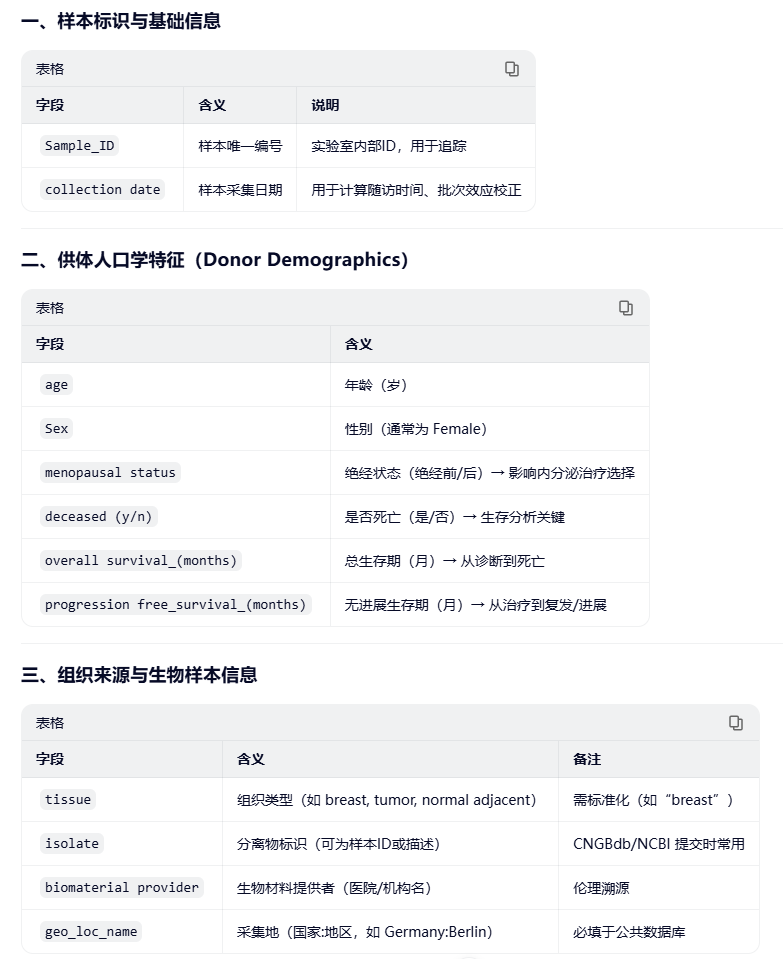
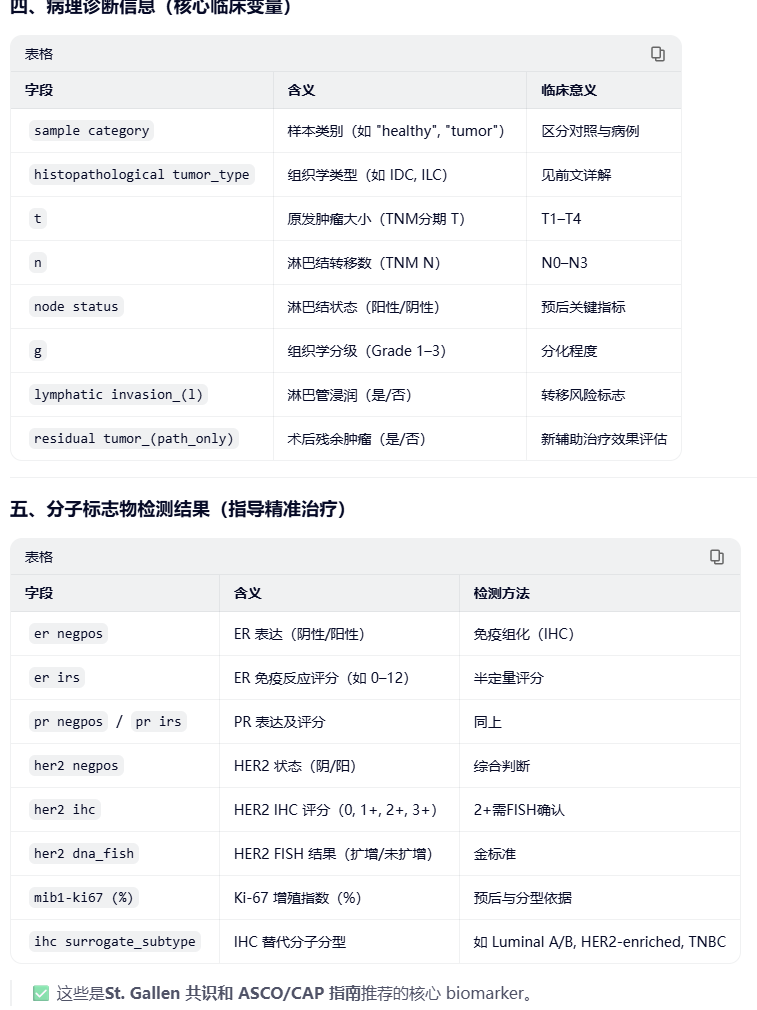
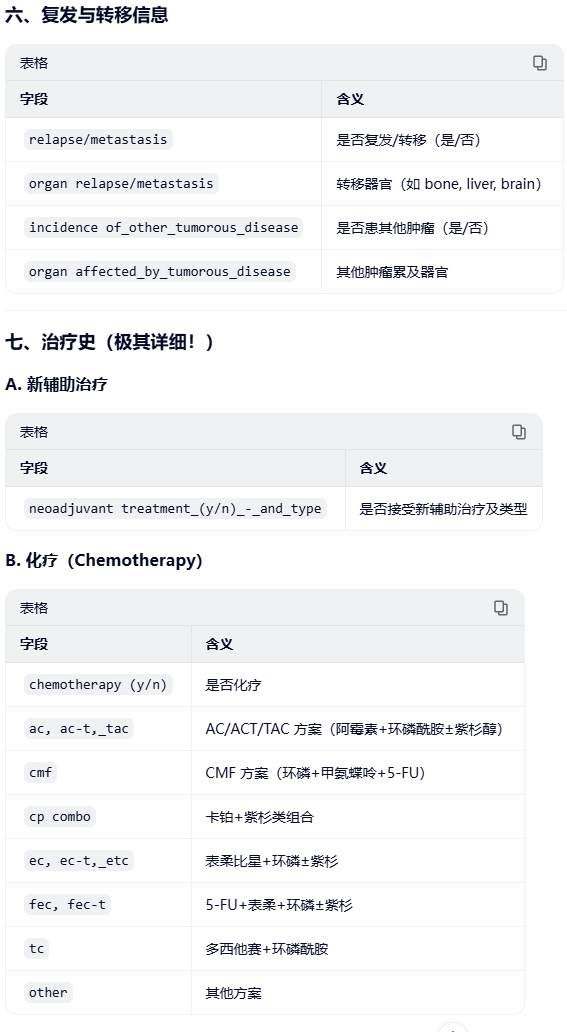
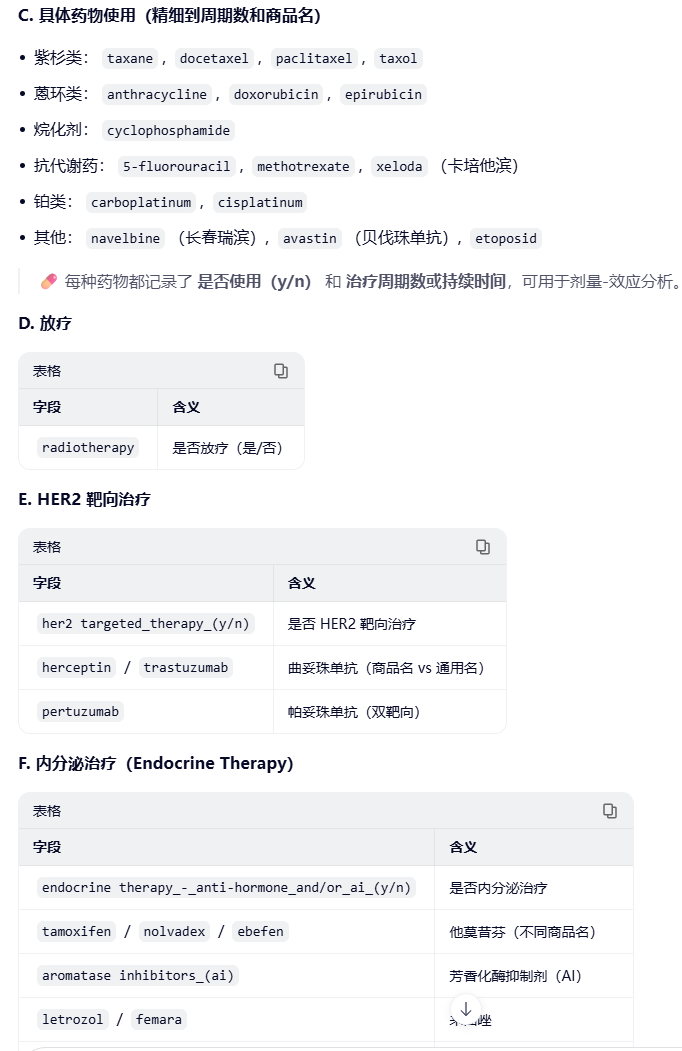
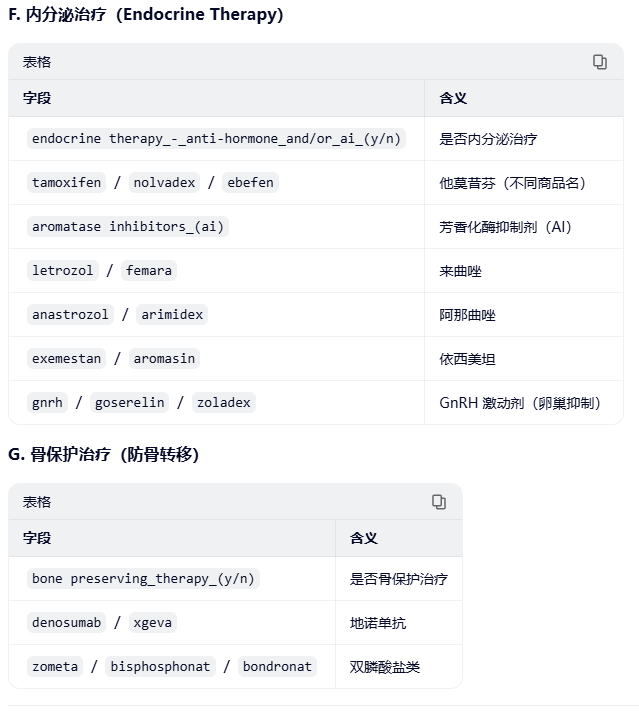

In [827]:
#Extract samples where isolate == 'healthy individual'
healthy_samples = meta_df[meta_df['isolate'] == 'healthy individual']

# 3. check tissue 和 sample category
print("For the 12 'healthy individual' samples:")
print("\nUnique values in 'tissue':")
print(healthy_samples['tissue'].value_counts(dropna=False))

print("\nUnique values in 'sample category':")
print(healthy_samples['sample category'].value_counts(dropna=False))

print("\nFirst few rows of these samples:")
display_cols = ['Sample_ID', 'tissue', 'sample category', 'histopathological tumor_type', 'er negpos', 'her2 negpos']
print(healthy_samples[display_cols].head(12))

For the 12 'healthy individual' samples:

Unique values in 'tissue':
breast    12
Name: tissue, dtype: int64

Unique values in 'sample category':
true healthy samples    12
Name: sample category, dtype: int64

First few rows of these samples:
      Sample_ID  tissue       sample category histopathological tumor_type  \
32   GSM8664637  breast  true healthy samples                      healthy   
33   GSM8664638  breast  true healthy samples                      healthy   
34   GSM8664639  breast  true healthy samples                      healthy   
35   GSM8664640  breast  true healthy samples                      healthy   
36   GSM8664641  breast  true healthy samples                      healthy   
37   GSM8664642  breast  true healthy samples                      healthy   
38   GSM8664643  breast  true healthy samples                      healthy   
39   GSM8664644  breast  true healthy samples                      healthy   
40   GSM8664645  breast  true healthy samples          

通过去GEO搜索GSM8664637样本ID，了解到这的确是健康组织，即阴性对照。为了验证信号在健康组织中“沉默”，确立 biomarker 的特异性，因此生成的对照组
阳性对照（Positive Control）
是已知会产生预期信号的样本
目的：验证整个检测流程（从样本到读数）能正确检出目标
在 HER2 FISH 检测中，使用 SK-BR-3 细胞系（已知 HER2 基因扩增）
isolate not applicable 是阳性对照


In [55]:
with pd.option_context(
    'display.max_columns', None,      # show all col
    'display.max_colwidth', None,     # Each column content is not truncated
    'display.width', None             # Automatically adjust console width
):

    
    print("\nFirst line of data (complete)First line of data (complete):")
    
    print(meta_df.iloc[579])


First line of data (complete)First line of data (complete):
Sample_ID                                       GSM8665184
tissue                                              breast
isolate                              breast cancer patient
age                                                70 - 74
biomaterial provider                          PATH biobank
                                             ...          
zometa (duration_in_years)                  not applicable
bisphosphonat (y/n)                                      N
bisphosphonat (duration_in_years)           not applicable
bondronat (y/n)                                          N
collection date                                       2013
Name: 579, Length: 120, dtype: object


In [757]:
print(meta_df[ 'patient_sample'].value_counts(dropna=False))

3038_20_748                      1
MDX_2702                         1
MDX_2665                         1
08T13                            1
MDX_2596_excluded_subtype        1
                                ..
MDX_2977                         1
MDX_2638                         1
3038_20_57_2_excluded_subtype    1
posMIX_36                        1
MDX_2508                         1
Name: patient_sample, Length: 1254, dtype: int64


## need to attention：
'isolate'：The sample contains positive and negative controls, which need to be considered.
'histopathological tumor_type'：Cancer subtype heterogeneity
herceptin vs trastuzumab：Duplicate entries in the product name and drug name columns
tamoxifen _(y/n)；nolvadex (tamoxifen)_(y/n)；ebefen (tamoxifen)_(y/n)and  three _(duration_in_years)：Just recorded using different product names or brand sources, all are tamoxifen
Aromatase Inhibitors, AIs）：Letrozole（：etrozol (ai)_(y/n)femara (ai,_letrozol)_(y/n)are same；Anastrozole：anastrozol (ai)_(y/n)and arimidex (ai,_anastrozol)_(y/n)are same；aromasin (ai/exemestan)_(y/n)&exemestan (ai)_(y/n)same
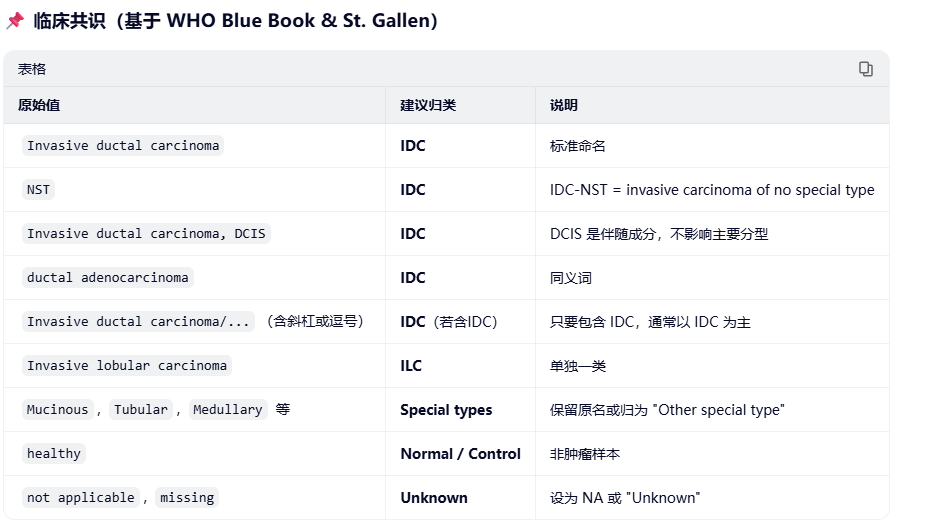

In [309]:
current_dir = os.getcwd()
print(current_dir)

/mnt/ONCOBOX/geneplus/workspace/chenly/data


## View gene data sample size

In [310]:
data_dir = Path("GSE283522_RAW")
files_paths = sorted(data_dir.glob("*.featureCounts.txt"))
print(f"found {len(files_paths)} samplefiles in total")
assert len(files_paths) > 0, "No featureCounts file found! Please check if the path is correct."

found 1254 samplefiles in total


# View content

In [311]:
# Preview the first few lines of the first file
sample_file = files_paths[888]
df_sample = pd.read_csv(sample_file, sep="\t", comment="#", nrows=5)
print(df_sample.head())

            Geneid                                                Chr  \
0  ENSG00000284662                                                  1   
1  ENSG00000186827                    1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1   
2  ENSG00000186891                1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1   
3  ENSG00000160072  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...   
4  ENSG00000041988  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...   

                                               Start  \
0                                             685679   
1  1211340;1211340;1211704;1211942;1211942;121201...   
2  1203508;1203508;1203844;1203844;1204034;120403...   
3  1471765;1471784;1477274;1477274;1478026;147864...   
4  6624866;6625150;6625171;6625181;6625192;662519...   

                                                 End  \
0                                             686673   
1  1211832;1211625;1211832;1212138;1212138;121213...   
2  1203968;1203960;1203968;1203968;1204236;120423...   


## Extract the original gene lengths, normalize gene_lengths, calculate Reads Per Kilobase to eliminate the influence of gene length. Normalize to millions to eliminate the influence of sequencing depth. Create a TPM matrix, as TPM has better comparability across samples, obtaining true gene expression levels.

In [829]:
# === Correctly extract the full gene length ===
sample_file = files_paths[0]  

skip = count_comment_lines(sample_file)
df_temp = pd.read_csv(sample_file, sep='\t', skiprows=skip)

# Clean column names
df_temp.columns = df_temp.columns.str.strip().str.replace('\ufeff', '', regex=False)

# Check key columns
if 'Geneid' not in df_temp.columns or 'Length' not in df_temp.columns:
    raise ValueError(f"file {sample_file.name} don't find 'Geneid' or 'Length' col！")

# Construct the complete gene_lengths Series (all genes)
gene_lengths = pd.Series(
    index=df_temp['Geneid'].values,
    data=df_temp['Length'].values,
    name='gene_length'
).astype(int)

print(f"Successfully extracted the length of {len(gene_lengths)}  genes")
print("such as：")
print(gene_lengths.head())

Successfully extracted the length of 60664  genes
such as：
ENSG00000284662     995
ENSG00000186827    1722
ENSG00000186891    1271
ENSG00000160072    7686
ENSG00000041988    4072
Name: gene_length, dtype: int64


In [830]:
def count_comment_lines(filepath):
    with open(filepath, 'r') as f:
        skip = 0
        for line in f:
            clean_line = line.strip()
            if clean_line.startswith('"') and clean_line.endswith('"'):
                clean_line = clean_line[1:-1].strip()
            if clean_line.startswith('#'):
                skip += 1
            else:
                break
        return skip

In [831]:
sample_series_list = []
for fp in files_paths:
    try:
        skip = count_comment_lines(fp)
        df = pd.read_csv(fp, sep='\t', skiprows=skip)
        
        sample_id = fp.name.split('_', 1)[0]
        gene_ids = df["Geneid"]
        counts = df.iloc[:, -1]
        
        series = pd.Series(counts.values, index=gene_ids, name=sample_id)
        sample_series_list.append(series)
    except Exception as e:
        print(f"skip {fp.name}: {e}")

# concat
count_matrix = pd.concat(sample_series_list, axis=1)
if count_matrix.index.has_duplicates:
    count_matrix = count_matrix.groupby(level=0).sum()

print(f"DONE! shape: {count_matrix.shape}")
print("such as:", count_matrix.columns[:3].tolist())

DONE! shape: (60664, 1254)
such as: ['GSM8664605', 'GSM8664606', 'GSM8664607']


In [315]:
count_matrix.head()

,GSM8664605,GSM8664606,GSM8664607,GSM8664608,GSM8664609,GSM8664610,GSM8664611,GSM8664612,GSM8664613,GSM8664614,...,GSM8665849,GSM8665850,GSM8665851,GSM8665852,GSM8665853,GSM8665854,GSM8665855,GSM8665856,GSM8665857,GSM8665858
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000284662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000186827,0,13,18,19,3,3,8,9,2,0,...,3,10,8,6,8,0,26,4,0,4
ENSG00000186891,4,35,15,18,2,3,43,33,18,6,...,8,10,2,7,12,1,8,4,3,2
ENSG00000160072,67,154,395,295,214,131,278,112,204,52,...,63,83,87,72,308,38,336,114,25,30
ENSG00000041988,20,49,49,35,54,17,51,37,29,14,...,21,19,16,22,383,11,66,30,8,5


In [832]:
common = count_matrix.index.intersection(gene_lengths.index)
count_sub = count_matrix.loc[common]
lengths_sub = gene_lengths.loc[common]
print(f"{len(common)} genes after align: ")

60664 genes after align: 


In [833]:
## readcount Data standardization
# Calculate RPK: Reads Per Kilobase
rpk = count_sub.div(lengths_sub / 1000, axis=0)

# Calculate per-million scaling factor
per_million = rpk.sum(axis=0) / 1e6

# Calculate TPM
tpm_matrix_ensembl = rpk.div(per_million, axis=1)

print("TPM metrics（Ensembl ID）shape:", tpm_matrix_ensembl.shape)

TPM metrics（Ensembl ID）shape: (60664, 1254)


In [245]:
tpm_matrix_ensembl.sum(axis=0).head()

GSM8664605    1000000.0
GSM8664606    1000000.0
GSM8664607    1000000.0
GSM8664608    1000000.0
GSM8664609    1000000.0
dtype: float64

In [367]:
tpm_matrix_ensembl.head

<bound method NDFrame.head of                  GSM8664605  GSM8664606  GSM8664607  GSM8664608  GSM8664609  \
ENSG00000284662    0.000000    0.000000    0.000000    0.000000    0.000000   
ENSG00000186827    0.000000    1.650143    3.940511    3.998642    0.515922   
ENSG00000186891    2.564798    6.019131    4.448964    5.132383    0.465994   
ENSG00000160072    7.104166    4.379572   19.373582   13.909571    8.245350   
ENSG00000041988    4.002772    2.630266    4.536297    3.114959    3.927188   
...                     ...         ...         ...         ...         ...   
ENSG00000271254    4.146943    1.450755    4.170084    2.325154    3.668980   
ENSG00000275987    0.000000    0.000000    0.000000    0.000000    0.000000   
ENSG00000268674    0.000000    0.000000    0.000000    0.000000    0.000000   
ENSG00000277475    0.980703    1.052132    0.453641    0.436105    1.069094   
ENSG00000275405    4.969296    3.998423   36.778105   17.678208   16.251534   

                 GSM8

# Preliminary screening to exclude non-protein-coding genes

In [834]:
#filter genes
def filter_protein_coding_safe(tpm_df, annot_file):
    """
   Robustly filter protein-coding genes

    Parameters:
        tpm_df (pd.DataFrame): Rows = Ensembl Gene ID, Columns = Samples, Values = TPM
        annot_file (str): Path to GENCODE annotation CSV file (must include gene_id, gene_type)

    Returns:
        pd.DataFrame: TPM subset containing only protein_coding genes
    """
    
    # 1.  annotations
    annot = pd.read_csv(annot_file, index_col=0)
    if 'gene_type' not in annot.columns:
        raise ValueError("annotations should contain 'gene_type' ")
    
    # 2. Processing duplicate gene IDs (taking the mean)
    if tpm_df.index.duplicated().any():
        print(f" Merging {tpm_df.index.duplicated().sum()} duplicate gene IDs")
        tpm_df = tpm_df.groupby(tpm_df.index).mean()
    
    # 3. Keep only genes present in the annotation (avoid invalid IDs)
    valid_genes = tpm_df.index.intersection(annot.index)
    if len(valid_genes) == 0:
        raise ValueError(" No common gene IDs found between TPM matrix and annotation file! Check ID format（Ensembl vs Symbol）")
    
    tpm_clean = tpm_df.loc[valid_genes]
    
    # 4. Filter protein_coding
    coding_mask = annot.loc[valid_genes, 'gene_type'] == 'protein_coding'
    tpm_coding = tpm_clean.loc[coding_mask]
    
    # 5. Verification result
    n_original = tpm_df.shape[0]
    n_final = tpm_coding.shape[0]
    print(f" Protein-coding gene filtering completed: {n_original} → {n_final} genes")
    
    return tpm_coding

# utlise
tpm_coding = filter_protein_coding_safe(
    tpm_df=tpm_matrix_ensembl,
    annot_file="gencode_v49_gene_annotation.csv"
)

 Protein-coding gene filtering completed: 60664 → 19954 genes


## Check and confirm that the key genes have not been deleted

In [835]:
# 1. Check HER2 (ERBB2) retention
assert 'ENSG00000141736' in tpm_coding.index, "HER2 gene lost！"

# 2. Check  lncRNA MALAT1  retention
assert 'ENSG00000251562' not in tpm_coding.index, "MALAT1 lost！"

# 3. Check if the quantity is reasonable
assert 18000 <= tpm_coding.shape[0] <= 21000, "Abnormal number of protein-coding genes！"

print("✅ All verifications passed! Filtering correct")

✅ All verifications passed! Filtering correct


In [836]:
##Switch from gene ID index to gene name index
# Ensure operating on the correct matrix: tpm_coding (not the original tpm_matrix_ensembl)
original_ids = tpm_coding.index.tolist()

# 2. Query using MyGene.info
mg = mygene.MyGeneInfo()
results = mg.querymany(
    original_ids,
    scopes='ensembl.gene',
    fields='symbol',
    species='human',
    as_dataframe=True,
    df_index=True  # Key： Ensure the returned DataFrame has query as the index
)

#  3. Build mapping dictionary (safely handle missing and multiple mappings)
symbol_map = {}
for gid in original_ids:
    if gid in results.index:
        sym = results.loc[gid, 'symbol']
        # Handling single result vs multiple results (MyGene returns Series or str)
        if isinstance(sym, pd.Series):
            sym = sym.iloc[0]  # Take the first match
        if pd.notna(sym) and sym != "":
            symbol_map[gid] = str(sym).upper()  # Convert to uppercase 
        else:
            symbol_map[gid] = gid
    else:
        symbol_map[gid] = gid

# 4. Apply new index to tpm_coding
tpm_with_symbol = tpm_coding.copy()
tpm_with_symbol.index = [symbol_map[gid] for gid in tpm_coding.index]

#  5. [Key] Handling duplicate gene names (multiple Ensembl IDs → same Symbol)  
# Strategy: Take the mean of duplicate rows (most common and reasonable approach)
duplicated_mask = tpm_with_symbol.index.duplicated(keep=False)
if duplicated_mask.any():
    print(f"Found {duplicated_mask.sum()} duplicate gene names, merging by mean...")
    tpm_with_symbol = tpm_with_symbol.groupby(tpm_with_symbol.index).mean()

print(f"Number of converted genes: {tpm_with_symbol.shape[0]}")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
2 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000175711', 2)]
2 input query terms found no hit:	['ENSG00000168078', 'ENSG00000189144']


Found 26 duplicate gene names, merging by mean...
Number of converted genes: 19941


In [837]:
# Check for duplicates
duplicated = tpm_with_symbol.index.duplicated(keep=False)
if duplicated.any():
    print(f"found {duplicated.sum()} duplicate gene names, merging by mean ...")
    # Key: Assign back to itself, and use mean()
    tpm_with_symbol = tpm_with_symbol.groupby(tpm_with_symbol.index).mean()

# Now tpm_with_symbol is a clean Symbol matrix
print(f"Final number of genes: {tpm_with_symbol.shape[0]}")

Final number of genes: 19941


In [838]:
tpm_matrix_final = tpm_with_symbol.groupby(level=0).sum()

print(f"final TPM metrics shape: {tpm_with_symbol.shape}")

final TPM metrics shape: (19941, 1254)


In [384]:
tpm_matrix_final.head()

,GSM8664605,GSM8664606,GSM8664607,GSM8664608,GSM8664609,GSM8664610,GSM8664611,GSM8664612,GSM8664613,GSM8664614,...,GSM8665849,GSM8665850,GSM8665851,GSM8665852,GSM8665853,GSM8665854,GSM8665855,GSM8665856,GSM8665857,GSM8665858
A1BG,1.630337,0.109318,0.942675,0.181247,0.740533,0.565112,0.727542,0.096260,0.262133,1.609607,...,0.399936,0.000000,0.364645,0.668322,0.252480,0.000000,0.319769,0.466720,0.000000,0.000000
A1CF,0.084866,0.068285,0.196280,0.339647,0.123353,0.117665,0.017822,0.000000,0.054580,0.095756,...,0.000000,0.124333,0.151850,0.389635,0.000000,0.382716,0.155356,0.116615,0.000000,0.000000
A2M,26.701115,17.402019,48.926871,60.400543,32.154384,65.814881,30.690983,107.416515,8.295896,22.995921,...,69.613701,59.276276,57.008491,68.782490,86.775684,42.929898,109.632585,86.496731,66.420955,82.947560
A2ML1,0.113885,0.213815,0.632156,1.063509,0.124150,0.631605,0.071748,0.107587,3.881937,0.257000,...,1.117484,0.945474,0.679252,0.971046,1.340390,0.410868,1.429575,0.938946,0.274032,1.194961
A3GALT2,1.593283,0.640998,0.000000,1.062766,1.157924,0.552268,0.334591,0.000000,0.000000,0.898872,...,2.345078,1.167123,0.950288,1.567518,0.000000,0.718518,1.041670,2.189343,1.916882,1.194126


In [386]:
tpm_matrix_transposed = tpm_matrix_final.T
print(tpm_matrix_transposed.head())

                A1BG      A1CF        A2M     A2ML1   A3GALT2     A4GALT  \
GSM8664605  1.630337  0.084866  26.701115  0.113885  1.593283   6.795416   
GSM8664606  0.109318  0.068285  17.402019  0.213815  0.640998   0.585832   
GSM8664607  0.942675  0.196280  48.926871  0.632156  0.000000  10.664884   
GSM8664608  0.181247  0.339647  60.400543  1.063509  1.062766   8.957555   
GSM8664609  0.740533  0.123353  32.154384  0.124150  1.157924  10.053560   

               A4GNT       AAAS      AACS     AADAC  ...     ZWILCH  \
GSM8664605  0.000000  14.826940  4.725463  0.000000  ...   5.543976   
GSM8664606  0.245734  10.080502  3.965765  0.133934  ...   4.280590   
GSM8664607  0.000000  15.630889  9.307459  0.230990  ...  12.356033   
GSM8664608  0.203712  11.499998  7.275631  0.444122  ...   9.711899   
GSM8664609  0.000000  14.847675  9.102597  0.000000  ...   3.907009   

                ZWINT      ZXDA      ZXDB       ZXDC     ZYG11A     ZYG11B  \
GSM8664605   7.542793  3.241060  5.664

In [387]:
tpm_matrix_transposed.shape

(1254, 19941)

## The sample clinical table and gene table are merged into a complete table by ID.

In [839]:
#Step 1: Ensure sample ID matches exactly (for diagnosis)
print("Sample intersection check::")
print(f"TPM sample count: {len(tpm_matrix_transposed.index)}")
print(f"Number of clinical samples: {len(df_meta_clean['Sample_ID'])}")
common_samples = set(tpm_matrix_transposed.index) & set(df_meta_clean['Sample_ID'])
print(f"Common sample size: {len(common_samples)}")

# Step 2: Extract TPM subset in the order of clinical table (strictly aligned)
ordered_samples = df_meta_clean['Sample_ID'].tolist()
# Keep only samples that exist in both TPM and clinical tables
ordered_samples_in_tpm = [s for s in ordered_samples if s in tpm_matrix_transposed.index]

tpm_ordered = tpm_matrix_transposed.loc[ordered_samples_in_tpm]  # (n_samples, n_genes)

# Step 3: Record gene column names (for subsequent safe extraction)
gene_columns = tpm_ordered.columns.tolist()  

# Step 4: Concatenate after resetting index (ensure row alignment)
clinical_reset = df_meta_clean.set_index('Sample_ID').loc[ordered_samples_in_tpm].reset_index()
tpm_reset = tpm_ordered.reset_index(drop=True)

final_df = pd.concat([clinical_reset, tpm_reset], axis=1)

print(f"\n Merge completed!!")
print(f"final_df shape: {final_df.shape}")  # 应为 (1036, N_clinical + 19962)
print(f"Number of gene columns: {len(gene_columns)}")

Sample intersection check::
TPM sample count: 1254
Number of clinical samples: 1254
Common sample size: 1254

 Merge completed!!
final_df shape: (1254, 20062)
Number of gene columns: 19941


In [790]:
final_df.head()


,Sample_ID,patient_sample,tissue,isolate,age,biomaterial provider,geo loc_name,Sex,sample category,menopausal status,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,GSM8664605,06T1,breast,breast cancer patient,55 - 59,hospital (Malaga),Spain,missing,invasive breast cancer sample,inferred postmenopausal,...,5.543976,7.542793,3.241060,5.664652,17.680359,6.076642,14.996300,60.617193,14.311121,28.407954
1,GSM8664606,07T1,breast,breast cancer patient,70 - 74,hospital (Malaga),Spain,missing,invasive breast cancer sample,inferred postmenopausal,...,4.280590,9.103687,1.999344,5.997268,24.246950,0.698489,7.218535,24.755054,11.294973,13.855398
2,GSM8664607,07T10,breast,breast cancer patient,25 - 29,hospital (Malaga),Spain,missing,invasive breast cancer sample,inferred premenopausal,...,12.356033,26.009253,4.797462,8.619343,16.305261,25.699230,22.831691,83.080016,27.072579,31.177487
3,GSM8664608,07T10_excluded_subtype,breast,breast cancer patient,25 - 29,hospital (Malaga),Spain,missing,extra ROI - invasive,inferred premenopausal,...,9.711899,22.869368,3.891385,6.164899,14.834354,22.544046,20.933359,78.204560,24.315324,24.541073
4,GSM8664609,07T11,breast,breast cancer patient,75 - 79,hospital (Malaga),Spain,missing,invasive breast cancer sample,inferred postmenopausal,...,3.907009,3.239216,2.473223,4.333478,18.869825,4.037686,8.913764,47.498277,14.855415,13.051422


In [791]:
final_df.shape

(1254, 20062)

In [840]:
final_df['Sample_ID'].unique()

array(['GSM8664605', 'GSM8664606', 'GSM8664607', ..., 'GSM8665856',
       'GSM8665857', 'GSM8665858'], dtype=object)

In [554]:
final_df['her2 negpos'].unique()

array(['P', 'N', 'missing', 'not applicable'], dtype=object)

In [555]:
print(final_df['her2 negpos'].value_counts())

N                 976
P                 224
not applicable     39
missing            15
Name: her2 negpos, dtype: int64


In [841]:
# Among the 36 samples with FISH, check whether they are consistent with her2 negpos.
fish_known = final_df[final_df['her2 dna_fish'].isin(['P', 'N'])]
print("FISH vs her2 negpos Consistency:")
print(pd.crosstab(fish_known['her2 negpos'], fish_known['her2 dna_fish']))

FISH vs her2 negpos Consistency:
her2 dna_fish   N   P
her2 negpos          
N              11   0
P               0  25


In [842]:
# Check whether missing is associated with HER2 status
missing_chemo = final_df['chemotherapy (y/n)'] == 'missing'
print("HER2 distribution in samples missing chemotherapy:")
print(final_df[missing_chemo]['her2 negpos'].value_counts())

HER2 distribution in samples missing chemotherapy:
N          38
P           5
missing     3
Name: her2 negpos, dtype: int64


# # Organize untreated clinical information + all protein transcription RNA gene expression data table

## Screening samples based on clinical characteristics
Healthy samples: used as negative control; FFPE samples of SK-BR-3 cells with high HER2 expression as positive control not applicable


In [843]:
df_meta_clean = meta_df.copy()

# Step 1: Check sample intersection (for diagnosis)
print("Sample intersection check:")
print(f"TPM sample count: {len(tpm_matrix_transposed.index)}")
print(f"Number of clinical samples: {len(df_meta_clean['Sample_ID'])}")
common_samples = set(tpm_matrix_transposed.index) & set(df_meta_clean['Sample_ID'])
print(f"Common sample size:: {len(common_samples)}")

if len(common_samples) == 0:
    raise ValueError("No common samples! Please check if Sample_ID matches (case sensitivity, prefix, suffix, etc.)")

# Step 2: Extract TPM subset in the order of clinical table (strictly aligned)
ordered_samples = df_meta_clean['Sample_ID'].tolist()
ordered_samples_in_tpm = [s for s in ordered_samples if s in tpm_matrix_transposed.index]

tpm_ordered = tpm_matrix_transposed.loc[ordered_samples_in_tpm]  # (n_samples, n_genes)

# Step 3: Record gene column name (for validation)
gene_columns = tpm_ordered.columns.tolist()
print(f"Number of genes: {len(gene_columns)}")

# Step 4: Align and merge
clinical_aligned = df_meta_clean.set_index('Sample_ID').loc[ordered_samples_in_tpm].reset_index()
tpm_reset = tpm_ordered.reset_index(drop=True)

# Merge: Clinical Information + Gene Expression
final_df = pd.concat([clinical_aligned, tpm_reset], axis=1)

print(f"\n Merged successfully!")
print(f"final_df shape: {final_df.shape}")  # (n_samples, n_clinical_cols + n_genes)



Sample intersection check:
TPM sample count: 1254
Number of clinical samples: 1254
Common sample size:: 1254
Number of genes: 19941

 Merged successfully!
final_df shape: (1254, 20062)


## Match patient ID

In [844]:
from sklearn.preprocessing import LabelEncoder

# Assuming your DataFrame is final_df

# 1. Define fingerprint fields
fingerprint_cols = [
    'Sex',
    'age',
    'menopausal status',
    'geo loc_name',
    'biomaterial provider',
    'histopathological tumor_type'
]

# 2. Handle missing values: uniformly replace NaN and "missing" with "MISSING"
df_fp = final_df[fingerprint_cols].fillna("MISSING")
df_fp = df_fp.replace("missing", "MISSING")  # GEO often has lowercase missing

# 3.Standardize age (to prevent inconsistencies such as "55-59" vs "55 - 59")
df_fp['age'] = df_fp['age'].str.replace(r'\s*-\s*', '-', regex=True)

# 4. Generate fingerprint string
final_df['Patient_Fingerprint'] = df_fp.apply(
    lambda row: '_'.join(row.astype(str)), axis=1
)

# 5. Assign a new Patient_ID for each unique fingerprint（P0001, P0002, ...）
fingerprint_to_id = {
    fp: f"P{i+1:05d}" 
    for i, fp in enumerate(final_df['Patient_Fingerprint'].unique())
}
final_df['Inferred_Patient_ID'] = final_df['Patient_Fingerprint'].map(fingerprint_to_id)
# Move the 'Inferred_Patient_ID' column to the front
final_df.insert(0, 'Inferred_Patient_ID', final_df.pop('Inferred_Patient_ID'))
# 6. Validation: Check conflicting cases (e.g., different ages under the same fingerprint? This should not occur)
print("\n=== Top 10 Patients by Sample Count ===")
print(final_df['Inferred_Patient_ID'].value_counts().head(10))



=== Top 10 Patients by Sample Count ===
P00426    39
P00324    37
P00323    24
P00321    23
P00326    23
P00327    21
P00322    21
P00348    15
P00369    15
P00376    13
Name: Inferred_Patient_ID, dtype: int64


In [810]:
print(final_df[ 'Inferred_Patient_ID'].value_counts(dropna=False))

P00426    39
P00324    37
P00323    24
P00321    23
P00326    23
          ..
P00186     1
P00024     1
P00370     1
P00194     1
P00122     1
Name: Inferred_Patient_ID, Length: 426, dtype: int64


## Combine synonymous columns  
## Merge synonymous/equivalent drug names, consolidate dosage/duration, generate "Aromatase Inhibitors (y/n)", and remove original redundant columns  
Note: Letrozole and Anastrozole are non-steroidal AIs with reversible inhibition;  
Exemestane is a steroidal AI with irreversible inhibition.  
Distinction may be necessary in mechanistic studies, but they are generally considered equivalent in efficacy/survival analyses. If the data clearly document medication use during different time periods, ideally the union of durations should be taken rather than simple summation.  
However, in real-world data, often only total duration is available, scattered across different fields, making summation a practical choice

In [845]:
def merge_yn_columns(row):
    """
    Merge multiple (y/n)

    Rules:
      1. If there is Y → 'Y'
      2. If no Y, there is N, and all other non-empty values are either N or missing → 'N' (conservative)
         
      3. All missing → 'missing'
      4. If there is NOT_APPLICABLE → 'not applicable'
    """
    non_missing_vals = []
    
    for val in row:
        # Standardized missing judgment
        if pd.isna(val) or str(val).strip() == '' or str(val).strip().lower() == 'missing':
            continue
        non_missing_vals.append(str(val).strip().upper())
    
    # Rule 3: All missing
    if not non_missing_vals:
        return 'missing'
    
    unique_vals = set(non_missing_vals)
    
    # Rule 1: Has Y
    if unique_vals & {'Y', 'YES'}:
        return 'Y'
    
    # Rule 4: Return NOT_APPLICABLE (return as long as it appears)
    if unique_vals & {'NOT APPLICABLE', 'N/A', 'NA', 'NOT_APPLICABLE'}:
        return 'not applicable'
    
    # Rule 2: The remaining can only be N
    if unique_vals <= {'N', 'NO'}:  # 是 {'N','NO'} 的子集
        return 'N'
    
    # Other cases (e.g., containing invalid values)→ 'missing'
    return 'missing'

def merge_duration_columns(row):
    total = 0.0
    valid_found = False
    for val in row:
        if pd.isna(val):
            continue
        try:
            num = float(val)
            if np.isfinite(num):
                total += num
                valid_found = True
        except (ValueError, TypeError):
            continue
    return total if valid_found else np.nan

# Original number of columns
initial_columns = set(final_df.columns)
initial_col_count = len(final_df.columns)
print(f"Initial number of columns: {initial_col_count}")
# ==============================
# STEP 1: Define the mapping relationship (new column + corresponding original column)
# ==============================

# Each new field: (new column name, [list of original columns], merge function)
merge_specs = [
    ('Trastuzumab (y/n)', ['herceptin (y/n)', 'trastuzumab (y/n)'], merge_yn_columns),
    
    ('Tamoxifen (y/n)', [
        'tamoxifen _(y/n)',
        'nolvadex (tamoxifen)_(y/n)',
        'ebefen (tamoxifen)_(y/n)'
    ], merge_yn_columns),
    ('Tamoxifen (duration_in_years)', [
        'tamoxifen _(duration_in_years)',
        'nolvadex (tamoxifen)(duration_in_years)',
        'ebefen (tamoxifen)_(duration_in_years)'
    ], merge_duration_columns),
    
    ('Letrozole (y/n)', ['letrozol (ai)_(y/n)', 'femara (ai,_letrozol)_(y/n)'], merge_yn_columns),
    ('Letrozole (duration_in_years)', [
        'letrozol (ai)_(duration_in_years)',
        'femara (ai,_letrozol)_(duration_in_years)'
    ], merge_duration_columns),
    
    ('Anastrozole (y/n)', ['anastrozol (ai)_(y/n)', 'arimidex (ai,_anastrozol)_(y/n)'], merge_yn_columns),
    ('Anastrozole (duration_in_years)', [
        'anastrozol (ai)_(duration_in_years)',
        'arimidex (ai,_anastrozol)_(duration_in_years)'
    ], merge_duration_columns),
    
    ('Exemestane (y/n)', ['exemestan (ai)_(y/n)', 'aromasin (ai/exemestan)_(y/n)'], merge_yn_columns),
    ('Exemestane (duration_in_years)', [
        'exemestan (ai)_(duration_in_years)',
        'aromasin (ai/exemestan)_(duration_in_years)'
    ], merge_duration_columns),
]

# ==============================
# STEP 2: Insert new columns at original positions
# ==============================

# First, collect all original columns to be deleted (for subsequent cleanup)
all_redundant_cols = set()

for new_col_name, raw_cols, func in merge_specs:
    # # Find the existing original columns
    existing_raw = [col for col in raw_cols if col in final_df.columns]
    if not existing_raw:
        continue
    
    # Record these columns as redundant
    all_redundant_cols.update(existing_raw)
    
    # Calculate insertion position: take the position of the first original column
    first_raw_col = existing_raw[0]
    insert_loc = final_df.columns.get_loc(first_raw_col)
    
    # Consolidated value
    merged_series = final_df[existing_raw].apply(func, axis=1)
    
    # Insert new column at this location
    final_df.insert(insert_loc, new_col_name, merged_series)

# ==============================
# STEP 3: Remove all original redundant columns (including those not used for merging but listed)
# ==============================


# Add other redundant columns (such as path column, subtype, etc.)
extra_redundant = [
    'herceptin (path', 'trastuzumab (path',
    'Patient_Fingerprint'
]

all_redundant_cols.update([col for col in extra_redundant if col in final_df.columns])

# Keep only the existing columns
cols_to_drop = [col for col in all_redundant_cols if col in final_df.columns]
final_df = final_df.drop(columns=cols_to_drop, errors='ignore')

# ==============================
# STEP 4: Process the AI Total column (it depends on newly generated columns, so add it last)
# ==============================

ai_any_cols = ['Letrozole (y/n)', 'Anastrozole (y/n)', 'Exemestane (y/n)']
existing_ai = [col for col in ai_any_cols if col in final_df.columns]
if existing_ai:
    ai_series = final_df[existing_ai].apply(
        lambda row: 'Y' if (row == 'Y').any() else 'N', axis=1
    )
    # Insert after the Exemestane column 
    if 'Exemestane (y/n)' in final_df.columns:
        loc = final_df.columns.get_loc('Exemestane (y/n)') + 1
    else:
        loc = len(final_df.columns)
    final_df.insert(loc, 'Aromatase Inhibitors (y/n)', ai_series)
# ==============================
# STEP 5: Validation & Output
# ==============================

final_columns = set(final_df.columns)
final_col_count = len(final_df.columns)

# Calculate add and delete columns
deleted_cols = sorted(initial_columns - final_columns)
added_cols = sorted(final_columns - initial_columns)

print("\n" + "="*60)
print(" Column Change Summary")
print("="*60)
print(f"Initial number of columns: {initial_col_count}")
print(f"Final number of columns: {final_col_count}")
print(f"Number of added columns: {len(added_cols)}")
print(f"Number of deleted columns: {len(deleted_cols)}")

if deleted_cols:
    print(f"\n Deleted columns ({len(deleted_cols)} total):")
    for col in deleted_cols:
        print(f"  - {col}")

if added_cols:
    print(f"\n Added columns ({len(added_cols)} total):")
    for col in added_cols:
        print(f"  - {col}")

# Original verification information (remains unchanged)
print("\n" + "="*60)
print("Data integration completed!！")
print("="*60)
print(f"Total number of samples: {len(final_df)}")
if 'Inferred_Patient_ID' in final_df.columns:
    print(f"Inferred number of patients: {final_df['Inferred_Patient_ID'].nunique()}")
print(f"Final dimension: {final_df.shape}")

# Show new column example
new_drug_cols = [
    'Trastuzumab (y/n)',
    'Tamoxifen (y/n)', 'Tamoxifen (duration_in_years)',
    'Letrozole (y/n)', 'Letrozole (duration_in_years)',
    'Anastrozole (y/n)', 'Anastrozole (duration_in_years)',
    'Exemestane (y/n)', 'Exemestane (duration_in_years)',
    'Aromatase Inhibitors (y/n)'
]
existing_new = [col for col in new_drug_cols if col in final_df.columns]
if existing_new:
    print("\n=== New drug field example ===")
    print(final_df[existing_new].head())

print("\n=== First 5 column examples ===")
print(final_df.iloc[:, :6].head())

# ==============================
# Print all column names
# ==============================
print("\n=== All column names (total {} columns）===".format(len(final_df.columns)))


Initial number of columns: 20064

 Column Change Summary
Initial number of columns: 20064
Final number of columns: 20051
Number of added columns: 10
Number of deleted columns: 23

 Deleted columns (23 total):
  - Patient_Fingerprint
  - anastrozol (ai)_(duration_in_years)
  - anastrozol (ai)_(y/n)
  - arimidex (ai,_anastrozol)_(duration_in_years)
  - arimidex (ai,_anastrozol)_(y/n)
  - aromasin (ai/exemestan)_(duration_in_years)
  - aromasin (ai/exemestan)_(y/n)
  - ebefen (tamoxifen)_(duration_in_years)
  - ebefen (tamoxifen)_(y/n)
  - exemestan (ai)_(duration_in_years)
  - exemestan (ai)_(y/n)
  - femara (ai,_letrozol)_(duration_in_years)
  - femara (ai,_letrozol)_(y/n)
  - herceptin (path
  - herceptin (y/n)
  - letrozol (ai)_(duration_in_years)
  - letrozol (ai)_(y/n)
  - nolvadex (tamoxifen)(duration_in_years)
  - nolvadex (tamoxifen)_(y/n)
  - tamoxifen _(duration_in_years)
  - tamoxifen _(y/n)
  - trastuzumab (path
  - trastuzumab (y/n)

 Added columns (10 total):
  - Anastrozol

In [849]:
# Locate the position of the 'collection date' column
target_col = 'collection date'

# Try exact match
if target_col in final_df.columns:
    idx = final_df.columns.get_loc(target_col)
    clinical_cols = final_df.columns[:idx + 1]  # 包含 'collection date'
else:
    # If not found, try vague matching
    found = None
    for col in final_df.columns:
        if col.strip().lower() == target_col.strip().lower():
            found = col
            break
    if found:
        idx = final_df.columns.get_loc(found)
        clinical_cols = final_df.columns[:idx + 1]
        print(f"Note: Using fuzzy matched column name '{found}' as 'collection date'")
    else:
        raise ValueError(f" Column '{target_col}' not found, please check if the column name is correct!")

print(f" A total of {len(clinical_cols)} clinical columns identified")
print("First 5 clinical column examples:", list(clinical_cols[:5]))
print("Last clinical column (should be collection date):", clinical_cols[-1])
with pd.option_context('display.max_seq_items', None):
    print(clinical_cols)

# ==============================
# STEP 2:Extract clinical data subset
# ==============================

clinical_df = final_df[clinical_cols].copy()

 A total of 110 clinical columns identified
First 5 clinical column examples: ['Inferred_Patient_ID', 'Sample_ID', 'patient_sample', 'tissue', 'isolate']
Last clinical column (should be collection date): collection date
Index(['Inferred_Patient_ID', 'Sample_ID', 'patient_sample', 'tissue',
       'isolate', 'age', 'biomaterial provider', 'geo loc_name', 'Sex',
       'sample category', 'menopausal status', 'histopathological tumor_type',
       't', 'n', 'node status', 'g', 'lymphatic invasion_(l)',
       'residual tumor_(path_only)', 'er negpos', 'er irs', 'pr negpos',
       'pr irs', 'her2 negpos', 'her2 ihc', 'her2 dna_fish', 'mib1-ki67 (%)',
       'ihc surrogate_subtype', 'deceased (y/n)', 'relapse/metastasis',
       'organ relapse/metastasis', 'incidence of_other_tumorous_disease',
       'organ affected_by_tumorous_disease', 'overall survival_(months)',
       'progression free_survival_(months)',
       'neoadjuvant treatment_(y/n)_-_and_type', 'chemotherapy (y/n)',
       '

In [859]:
# ==============================
# STEP 3: Save as Excel File
# ==============================

output_file = "clinical_data.xlsx"
clinical_df.to_excel(output_file, index=False)

print(f"\n Clinical data has been successfully saved to: {output_file}")
print(f"shape： {clinical_df.shape} (row, col)")


 Clinical data has been successfully saved to: clinical_data.xlsx
shape： (1254, 110) (row, col)


## Confirm the patient's medication status

In [851]:
# Patient ID column
patient_id_col = 'Inferred_Patient_ID'

# Define the specific drug "y/n" column
drug_columns = [
    'taxane (y/n)',
    'docetaxel (taxotere,_taxan)_(y/n)',
    'paclitaxel (abraxane)_(y/n)',
    'taxol (y/n)',
    'anthracycline (y/n)',
    'doxorubicin (adriamycin,_myocet,_caleyx)_(y/n)',
    'epirubicin (y/n)',
    'cyclophosphamide (endoxan)_(y/n)',
    'antimetabolites',
    '5-fluorouracil (y/n)',
    'methotrexate (y/n)',
    'xeloda (y/n)',
    'carboplatinum (y/n)',
    'cisplatinum (y/n)',
    'navelbine (y/n)',
    'avastin (y/n)',
    'etoposid (y/n)',
    'Trastuzumab (y/n)',
    'pertuzumab (y/n)',
    'endocrine therapy_-_anti-hormone_and/or_ai_(y/n)',
    'anti-hormonal therapy_(y/n)',
    'Tamoxifen (y/n)',
    'aromatase inhibitors_(y/n)',
    'Letrozole (y/n)',
    'Anastrozole (y/n)',
    'Exemestane (y/n)',
    'Aromatase Inhibitors (y/n)',
    'gnrh (y/n)',
    'goserelin (gnrh)__(y/n)',
    'zoladex (gnrh,_goserelin)_(y/n)',
    'bone preserving_therapy_(y/n)',
    'denosumab (y/n)',
    'xgeva (denosumab)_(y/n)',
    'zometa (y/n)',
    'bisphosphonat (y/n)',
    'bondronat (y/n)'
]

def get_drug_combination(group):
    """For each patient group, return the standardized string of their medication combination"""
    # Retrieve all medication column values for this patient (take the first row)
    drug_values = group[drug_columns].iloc[0]
    
    # Find all drugs with a value of "Y"
    used_drugs = drug_values[drug_values == 'Y'].index.tolist()
    
    # Return "no_drugs" if no medication is used
    if not used_drugs:
        return "no_drugs"
    
    # Sort drug names to ensure that identical combinations always generate the same string
    used_drugs.sort()
    
    # Return the standardized composite string
    return "(" + ", ".join(used_drugs) + ")"

# Apply the function to each patient to obtain their medication combination
patient_combinations = clinical_df.groupby(patient_id_col).apply(get_drug_combination)

# Count the number of people for each medication combination
combination_counts = patient_combinations.value_counts()

# Sort by number of people from most to least (value_counts() is in descending order by default)
sorted_combinations = combination_counts.sort_values(ascending=False)
total_patients = len(patient_combinations)
# print the result
print(f"Number of people（all {total_patients} in total）")
print("Medication combination: number of people")
print("=" * 80)
for combination, count in sorted_combinations.items():
    print(f"{combination}: {count}")

Number of people（all 426 in total）
Medication combination: number of people
no_drugs: 58
(Tamoxifen (y/n), anti-hormonal therapy_(y/n), endocrine therapy_-_anti-hormone_and/or_ai_(y/n)): 31
(anti-hormonal therapy_(y/n), aromatase inhibitors_(y/n), endocrine therapy_-_anti-hormone_and/or_ai_(y/n)): 24
(Anastrozole (y/n), Aromatase Inhibitors (y/n), aromatase inhibitors_(y/n), endocrine therapy_-_anti-hormone_and/or_ai_(y/n)): 24
(5-fluorouracil (y/n), anthracycline (y/n), antimetabolites, cyclophosphamide (endoxan)_(y/n), docetaxel (taxotere,_taxan)_(y/n), epirubicin (y/n), taxane (y/n)): 21
(anti-hormonal therapy_(y/n), endocrine therapy_-_anti-hormone_and/or_ai_(y/n)): 15
(Aromatase Inhibitors (y/n), Letrozole (y/n), aromatase inhibitors_(y/n), endocrine therapy_-_anti-hormone_and/or_ai_(y/n)): 14
(Anastrozole (y/n), Aromatase Inhibitors (y/n), anti-hormonal therapy_(y/n), aromatase inhibitors_(y/n), endocrine therapy_-_anti-hormone_and/or_ai_(y/n)): 11
(5-fluorouracil (y/n), anthracy

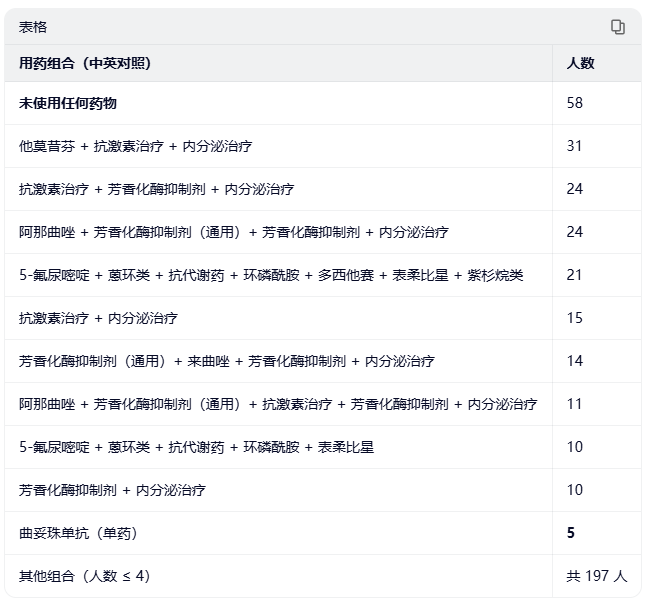

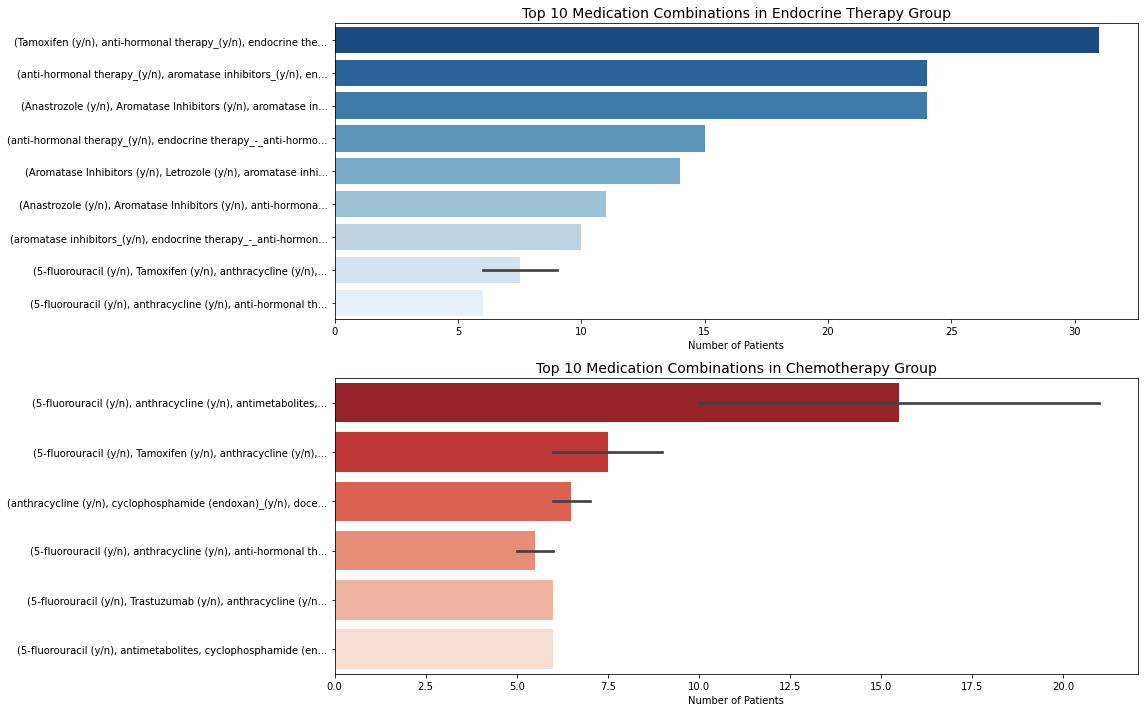

In [853]:
patient_id_col = 'Inferred_Patient_ID'
def classify_patient(group):
    """Generate treatment classification and medication combination strings for each patient"""
    row = group.iloc[0] 
    used_drugs = []
    
    for col in drug_columns:
        if col in row.index and row[col] == 'Y':
            used_drugs.append(col)
    
    # Construct standardized combination string
    if not used_drugs:
        combo_str = "no_drugs"
    else:
        used_drugs.sort()
        combo_str = "(" + ", ".join(used_drugs) + ")"
    
    # Determine whether it belongs to endocrine therapy
    endo_keywords = {
        'endocrine therapy_-_anti-hormone_and/or_ai_(y/n)',
        'anti-hormonal therapy_(y/n)',
        'Tamoxifen (y/n)',
        'aromatase inhibitors_(y/n)',
        'Letrozole (y/n)',
        'Anastrozole (y/n)',
        'Exemestane (y/n)',
        'Aromatase Inhibitors (y/n)',
        'gnrh (y/n)',
        'goserelin (gnrh)__(y/n)',
        'zoladex (gnrh,_goserelin)_(y/n)'
    }
    is_endo = any(kw in used_drugs for kw in endo_keywords)
    
    # Determine whether chemotherapy is needed
    chemo_keywords = {
        'taxane (y/n)', 'docetaxel (taxotere,_taxan)_(y/n)', 'paclitaxel (abraxane)_(y/n)', 'taxol (y/n)',
        'anthracycline (y/n)', 'doxorubicin (adriamycin,_myocet,_caleyx)_(y/n)', 'epirubicin (y/n)',
        'cyclophosphamide (endoxan)_(y/n)', '5-fluorouracil (y/n)', 'methotrexate (y/n)', 'xeloda (y/n)',
        'carboplatinum (y/n)', 'cisplatinum (y/n)', 'navelbine (y/n)', 'etoposid (y/n)', 'antimetabolites'
    }
    is_chemo = any(kw in used_drugs for kw in chemo_keywords)
    
    # Whether to use trastuzumab
    is_trast = 'Trastuzumab (y/n)' in used_drugs
    
    return pd.Series({
        'combination_str': combo_str,
        'endo': is_endo,
        'chemo': is_chemo,
        'trastuzumab': is_trast
    })

# Application Classification
patient_labels = clinical_df.groupby(patient_id_col).apply(classify_patient).reset_index()

# Now patient_labels contains:: Inferred_Patient_ID, combination_str, endo, chemo, trastuzumab

# Filter out no_drugs
treated_patients = patient_labels[patient_labels['combination_str'] != 'no_drugs']

#Count each group top Combination
endo_combos = treated_patients[treated_patients['endo']]['combination_str'].value_counts().head(10)
chemo_combos = treated_patients[treated_patients['chemo']]['combination_str'].value_counts().head(10)
trast_combos = treated_patients[treated_patients['trastuzumab']]['combination_str'].value_counts().head(10)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))

# Endocrine therapy group
plt.subplot(2, 1, 1)
sns.barplot(x=endo_combos.values, y=[s[:60]+'...' if len(s)>60 else s for s in endo_combos.index], palette='Blues_r')
plt.title('Top 10 Medication Combinations in Endocrine Therapy Group', fontsize=14)
plt.xlabel('Number of Patients')

# Chemotherapy group
plt.subplot(2, 1, 2)
sns.barplot(x=chemo_combos.values, y=[s[:60]+'...' if len(s)>60 else s for s in chemo_combos.index], palette='Reds_r')
plt.title('Top 10 Medication Combinations in Chemotherapy Group', fontsize=14)
plt.xlabel('Number of Patients')

plt.tight_layout()
plt.savefig('endo_vs_chemo_combinations.png', dpi=300, bbox_inches='tight')
plt.show()


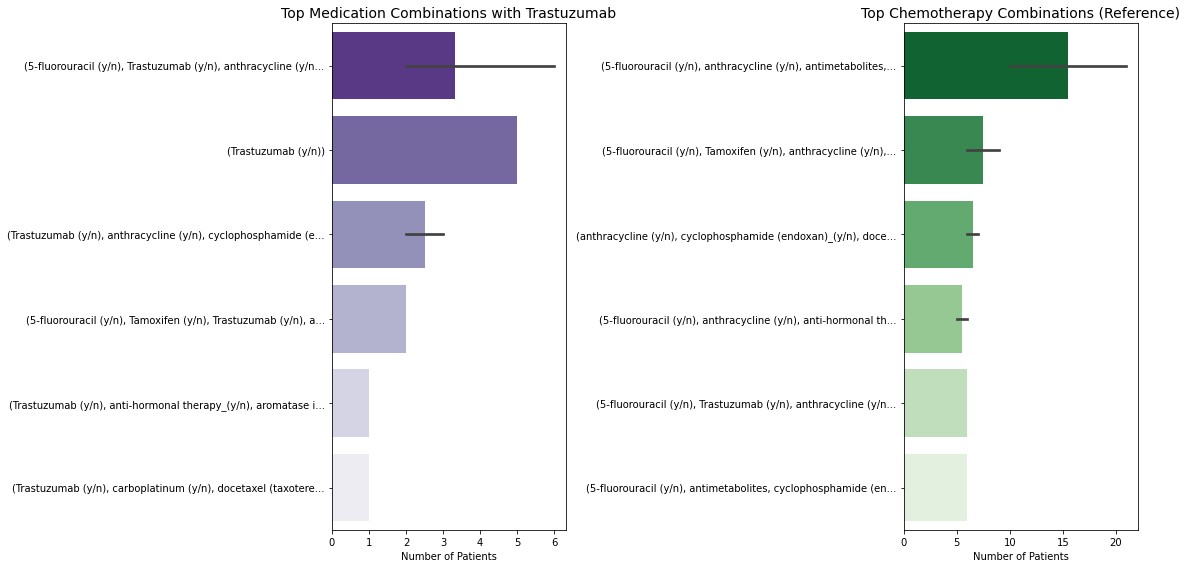

In [854]:
plt.figure(figsize=(16, 8))

# Trastuzumab group
plt.subplot(1, 2, 1)
if not trast_combos.empty:
    sns.barplot(x=trast_combos.values, y=[s[:60]+'...' if len(s)>60 else s for s in trast_combos.index], palette='Purples_r')
else:
    plt.text(0.5, 0.5, 'No Trastuzumab users', ha='center', va='center')
plt.title('Top Medication Combinations with Trastuzumab', fontsize=14)
plt.xlabel('Number of Patients')

# chemo
plt.subplot(1, 2, 2)
sns.barplot(x=chemo_combos.values, y=[s[:60]+'...' if len(s)>60 else s for s in chemo_combos.index], palette='Greens_r')
plt.title('Top Chemotherapy Combinations (Reference)', fontsize=14)
plt.xlabel('Number of Patients')

plt.tight_layout()
plt.savefig('trastuzumab_vs_chemo_combinations.png', dpi=300, bbox_inches='tight')
plt.show()

In [856]:
print(final_df[ 'Trastuzumab (y/n)'].value_counts(dropna=False))

N                 964
Y                 186
missing            53
not applicable     51
Name: Trastuzumab (y/n), dtype: int64


In [819]:
final_df.columns

Index(['Inferred_Patient_ID', 'Sample_ID', 'patient_sample', 'tissue',
       'isolate', 'age', 'biomaterial provider', 'geo loc_name', 'Sex',
       'sample category',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=20051)

In [820]:
final_df.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['Inferred_Patient_ID', 'Sample_ID', 'patient_sample', 'tissue',
       'isolate', 'age', 'biomaterial provider', 'geo loc_name', 'Sex',
       'sample category',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=20051)>

### Exclude samples with missing result information, which are unusable

In [860]:
# Define two survival time columns
os_col = 'overall survival_(months)'
pfs_col = 'progression free_survival_(months)'

# Convert "missing" to NaN (optional, for easier subsequent processing)
# But for safety, we directly use string comparison

# Create a boolean mask: check if it is "missing" (case-insensitive)
os_is_missing = final_df[os_col].astype(str).str.lower().str.strip() == 'missing'
pfs_is_missing = final_df[pfs_col].astype(str).str.lower().str.strip() == 'missing'

# Find the rows where both OS and PFS are "missing"
both_missing_mask = os_is_missing & pfs_is_missing

print(f"Number of sample rows where both OS and PFS are 'missing': {both_missing_mask.sum()}")

# Delete these lines
final_df_clean = final_df[~both_missing_mask].reset_index(drop=True)

# Count remaining patients
remaining_patients = final_df_clean['Inferred_Patient_ID'].nunique()
print(f"Number of patients remaining (unique) after deletion Inferred_Patient_ID): {remaining_patients}")


# View deleted patients
deleted_patients = final_df[both_missing_mask]['Inferred_Patient_ID'].unique()
print(f"Number of patients completely deleted (all samples of these patients have no OS/PFS): {len(deleted_patients)}")
final_df = final_df_clean

Number of sample rows where both OS and PFS are 'missing': 94
Number of patients remaining (unique) after deletion Inferred_Patient_ID): 393
Number of patients completely deleted (all samples of these patients have no OS/PFS): 60


In [822]:
print(final_df.shape)

(1160, 20051)


In [861]:
# 1.. Get the column names and count of clinical features
clinical_cols = clinical_reset.columns.tolist()
n_clinical = len(clinical_cols)

# 2. Get gene (TPM) column names and count
gene_cols = tpm_reset.columns.tolist()
n_genes = len(gene_cols)

# 3. Print results
print(f"📊 Number of clinical features: {n_clinical}")
print(f"🧬 Number of genes (TPM): {n_genes}")
print(f"✅ Total number of columns after merging:: {final_df.shape[1]}")

#
print("\n--- Top 5 clinical features ---")
print(clinical_cols[:5])

print("\n--- The first 5 genes---")
print(gene_cols[:5])

📊 Number of clinical features: 121
🧬 Number of genes (TPM): 19941
✅ Total number of columns after merging:: 20051

--- Top 5 clinical features ---
['Sample_ID', 'patient_sample', 'tissue', 'isolate', 'age']

--- The first 5 genes---
['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2']


## Check the overlap between patients and samples

In [862]:
# 1. Count the number of samples for each patient
sample_count_per_patient = final_df.groupby('Inferred_Patient_ID').size()

# 2. View distribution: number of patients corresponding to each sample count
distribution = sample_count_per_patient.value_counts().sort_index()

# 3. Print results
print("📊 Distribution of the number of samples per patient:：")
print("(Format: Sample count -> Number of patients)")
for n_samples, n_patients in distribution.items():
    print(f"  {n_samples} samples -> {n_patients} patients")

print(f"\n✅ Total number of patients: {len(sample_count_per_patient)}")
print(f"✅ Total number of samples: {final_df_clean.shape[0]}")

# 4. Optional: View which specific patients have multiple samples (e.g., >1)
multi_sample_patients = sample_count_per_patient[sample_count_per_patient > 1]
if not multi_sample_patients.empty:
    print(f"\n🔍 There are {len(multi_sample_patients)} patients with multiple samples, for example：")
    print(multi_sample_patients.head(10).to_string())

📊 Distribution of the number of samples per patient:：
(Format: Sample count -> Number of patients)
  1 samples -> 198 patients
  2 samples -> 59 patients
  3 samples -> 42 patients
  4 samples -> 28 patients
  5 samples -> 15 patients
  6 samples -> 15 patients
  7 samples -> 7 patients
  8 samples -> 7 patients
  9 samples -> 6 patients
  10 samples -> 2 patients
  11 samples -> 3 patients
  12 samples -> 2 patients
  13 samples -> 1 patients
  15 samples -> 1 patients
  19 samples -> 2 patients
  20 samples -> 1 patients
  21 samples -> 1 patients
  23 samples -> 1 patients
  36 samples -> 1 patients
  39 samples -> 1 patients

✅ Total number of patients: 393
✅ Total number of samples: 1160

🔍 There are 195 patients with multiple samples, for example：
Inferred_Patient_ID
P00018     4
P00022     2
P00023     3
P00025     6
P00026    11
P00029     6
P00030     5
P00031     2
P00033    10
P00036     3


In [863]:
healthy_individuals = final_df[final_df_clean['isolate'] == 'healthy individual']
print("\n Healthy individual sample ID (total of {}）:".format(len(healthy_individuals)))
print(healthy_individuals[['Inferred_Patient_ID', 'patient_sample']].drop_duplicates())


 Healthy individual sample ID (total of 12）:
    Inferred_Patient_ID         patient_sample
0                P00017      21G_19879_healthy
1                P00018      22G_12375_healthy
2                P00019      22G_12520_healthy
3                P00018      22G_12522_healthy
4                P00020       22G_1894_healthy
5                P00018       22G_1898_healthy
6                P00021       22G_1905_healthy
7                P00022       22G_1916_healthy
8                P00018       22G_1930_healthy
434              P00207  MDX_21G_17404_healthy
435              P00208  MDX_21G_20663_healthy
436              P00022   MDX_22G_1617_healthy


In [864]:
# # 1. Create retention condition: retain only rows where isolate is "breast cancer patient"
keep_mask = final_df_clean['isolate'] == 'breast cancer patient'

# 2. Application Filter
final_df_pure = final_df_clean[keep_mask].reset_index(drop=True)

# 3. Statistical results
remaining_samples = len(final_df_pure)
remaining_patients = final_df_pure['Inferred_Patient_ID'].nunique()

print(f"✅ Number of remaining samples after cleaning:: {remaining_samples}")
print(f"✅ The number of unique patients remaining after cleaning (Inferred_Patient_ID): {remaining_patients}")

# 4.Verify whether the target ID has been deleted
if 'P00426' in final_df_pure['Inferred_Patient_ID'].values:
    print("⚠️ Warning: P00426 is still in the data!！")
else:
    print("✅ P00426(Positive control) has been successfully removed")

# Check if there are any healthy individuals left
has_healthy = (final_df_pure['isolate'] == 'healthy individual').any()
has_na = (final_df_pure['isolate'] == 'not applicable').any()
if not has_healthy and not has_na:
    print("✅All non-real patient samples (healthy + positive control) have been removed")

✅ Number of remaining samples after cleaning:: 1109
✅ The number of unique patients remaining after cleaning (Inferred_Patient_ID): 384
✅ P00426(Positive control) has been successfully removed
✅All non-real patient samples (healthy + positive control) have been removed


In [865]:
# 1. Filter: Keep only isolate == 'breast cancer patient'
keep_mask = final_df_clean['isolate'] == 'breast cancer patient'
final_df = final_df_clean[keep_mask].reset_index(drop=True) 

# 2. Count the total number of samples and patients
total_samples = len(final_df)
total_patients = final_df['Inferred_Patient_ID'].nunique()
print(f"✅Total number of samples: {total_samples}")
print(f"✅ Total number of patients: {total_patients}")

# 3. Calculate the distribution of sample counts for each patient
sample_count_per_patient = final_df.groupby('Inferred_Patient_ID').size()
distribution = sample_count_per_patient.value_counts().sort_index()

print("\n Distribution of the number of samples per patient:：")

for n_samples, n_patients in distribution.items():
    print(f"{n_samples} samples from {n_patients} patients ")

# 4. Verify whether P00426 and non-patients have been cleared
assert 'P00426' not in final_df['Inferred_Patient_ID'].values, "P00426 Not deleted！"
assert not (final_df['isolate'] == 'healthy individual').any(), "still exist healthy individual！"
assert not (final_df['isolate'] == 'not applicable').any(), "still exist positive control！"
print("\n✅ All non-real patient samples have been successfully removed, and final_df is ready！")

✅Total number of samples: 1109
✅ Total number of patients: 384

 Distribution of the number of samples per patient:：
1 samples from 192 patients 
2 samples from 58 patients 
3 samples from 42 patients 
4 samples from 27 patients 
5 samples from 15 patients 
6 samples from 15 patients 
7 samples from 7 patients 
8 samples from 7 patients 
9 samples from 6 patients 
10 samples from 2 patients 
11 samples from 3 patients 
12 samples from 2 patients 
13 samples from 1 patients 
15 samples from 1 patients 
19 samples from 2 patients 
20 samples from 1 patients 
21 samples from 1 patients 
23 samples from 1 patients 
36 samples from 1 patients 

✅ All non-real patient samples have been successfully removed, and final_df is ready！


In [866]:
# 1. Count the number of samples for each patient
sample_count = final_df.groupby('Inferred_Patient_ID').size()

# 2. Filter patients with sample count >= 10
high_sample_patients = sample_count[sample_count >= 10].sort_values(ascending=False)

# 3. Print result: Number of samples and ID per patient
print("🔍 High-density sampling patients (≥10 samples):")
print("(Format: Patient ID → Sample Count)")
for patient_id, n_samples in high_sample_patients.items():
    print(f"  {patient_id} → {n_samples} a sample")

# 4. (Optional) Save these IDs as a list for easier subsequent analysis
high_sample_ids = high_sample_patients.index.tolist()
print(f"\n✅ A total of {len(high_sample_ids)} patients have ≥10 samples")

🔍 High-density sampling patients (≥10 samples):
(Format: Patient ID → Sample Count)
  P00324 → 36 a sample
  P00321 → 23 a sample
  P00322 → 21 a sample
  P00323 → 20 a sample
  P00327 → 19 a sample
  P00326 → 19 a sample
  P00369 → 15 a sample
  P00376 → 13 a sample
  P00348 → 12 a sample
  P00332 → 12 a sample
  P00133 → 11 a sample
  P00044 → 11 a sample
  P00026 → 11 a sample
  P00378 → 10 a sample
  P00033 → 10 a sample

✅ A total of 15 patients have ≥10 samples


In [867]:
# For example, view the patient with the most samples
top_patient = high_sample_ids[0]
top_data = final_df[final_df['Inferred_Patient_ID'] == top_patient]

# Check if there is heterogeneity in key fields
cols_of_interest = [
    'histopathological tumor_type',
    'er negpos', 'pr negpos', 'her2 negpos',
    'mib1-ki67 (%)',
    'collection date',
    'geo loc_name'
]
print(f"\n--- Key characteristics of patient {top_patient} ---")
print(top_data[cols_of_interest])


--- Key characteristics of patient P00324 ---
    histopathological tumor_type er negpos pr negpos her2 negpos  \
735    Invasive ductal carcinoma         P         P           N   
736    Invasive ductal carcinoma         P         P           N   
752    Invasive ductal carcinoma         N         N           P   
759    Invasive ductal carcinoma         P         P           P   
766    Invasive ductal carcinoma         P         P           N   
771    Invasive ductal carcinoma         P         P           N   
772    Invasive ductal carcinoma         N         N           N   
773    Invasive ductal carcinoma         N         N           N   
777    Invasive ductal carcinoma         N         N           P   
778    Invasive ductal carcinoma         N         N           P   
779    Invasive ductal carcinoma         N         N           P   
792    Invasive ductal carcinoma         P         P           N   
836    Invasive ductal carcinoma         P         N           P   
8

In [776]:
print(clinical_cols)

['Sample_ID', 'patient_sample', 'tissue', 'isolate', 'age', 'biomaterial provider', 'geo loc_name', 'Sex', 'sample category', 'menopausal status', 'histopathological tumor_type', 't', 'n', 'node status', 'g', 'lymphatic invasion_(l)', 'residual tumor_(path_only)', 'er negpos', 'er irs', 'pr negpos', 'pr irs', 'her2 negpos', 'her2 ihc', 'her2 dna_fish', 'mib1-ki67 (%)', 'ihc surrogate_subtype', 'deceased (y/n)', 'relapse/metastasis', 'organ relapse/metastasis', 'incidence of_other_tumorous_disease', 'organ affected_by_tumorous_disease', 'overall survival_(months)', 'progression free_survival_(months)', 'neoadjuvant treatment_(y/n)_-_and_type', 'chemotherapy (y/n)', 'ac, ac-t,_tac', 'cmf', 'cp combo', 'ec, ec-t,_etc', 'fec, fec-t', 'tc', 'other', 'taxane (y/n)', 'docetaxel (taxotere,_taxan)_(y/n)', 'docetaxel (taxotere,_taxan)_(cycles)', 'paclitaxel (abraxane)_(y/n)', 'paclitaxel (abraxane)_(cycles)', 'taxol (y/n)', 'taxol dosage', 'anthracycline (y/n)', 'anthracycline (cycles)', 'doxoru

In [777]:
final_df.head()

,Inferred_Patient_ID,Sample_ID,patient_sample,tissue,isolate,age,biomaterial provider,geo loc_name,Sex,sample category,...,Trastuzumab (y/n),Tamoxifen (y/n),Tamoxifen (duration_in_years),Letrozole (y/n),Letrozole (duration_in_years),Anastrozole (y/n),Anastrozole (duration_in_years),Exemestane (y/n),Exemestane (duration_in_years),Aromatase Inhibitors (y/n)
0,P00023,GSM8664646,3038_20_1,breast,breast cancer patient,55 - 59,GRAZ biobank,Austria: Graz 1st shipment,female,invasive breast cancer sample,...,N,N,NaN,N,NaN,N,NaN,N,NaN,N
1,P00024,GSM8664647,3038_20_103,breast,breast cancer patient,55 - 59,GRAZ biobank,Austria: Graz 6th shipment,female,invasive breast cancer sample,...,N,N,NaN,N,NaN,N,NaN,Y,4.916667,Y
2,P00025,GSM8664648,3038_20_104,breast,breast cancer patient,75 - 79,GRAZ biobank,Austria: Graz 6th shipment,female,invasive breast cancer sample,...,N,N,NaN,N,NaN,Y,NaN,N,NaN,Y
3,P00023,GSM8664649,3038_20_106,breast,breast cancer patient,55 - 59,GRAZ biobank,Austria: Graz 1st shipment,female,invasive breast cancer sample,...,N,Y,2.0,N,NaN,N,NaN,N,NaN,N
4,P00026,GSM8664650,3038_20_11,breast,breast cancer patient,45 - 49,GRAZ biobank,Austria: Graz 1st shipment,female,invasive breast cancer sample,...,N,N,NaN,N,NaN,N,NaN,N,NaN,N


In [868]:
clinical_cols_in_df = [col for col in clinical_cols if col in final_df.columns]

# Extract clinical subset
clinical_df = final_df[clinical_cols_in_df]
# Save clinical data to Excel
output_file = "breastcancer_clinical_data_only.xlsx"
clinical_df.to_excel(output_file, index=False, na_rep="NA")
print(f"✅ Successfully saved {clinical_df.shape[0]} rows × {clinical_df.shape[1]} columns to {output_file}")

✅ Successfully saved 1109 rows × 99 columns to breastcancer_clinical_data_only.xlsx


In [869]:
# Total number of patients (including those not receiving treatment)
total_patients = len(patient_labels)
print(f"Total number of patients: {total_patients}")

# Count only treated patients (excluding 'no_drugs')
treated_patients = patient_labels[patient_labels['combination_str'] != 'no_drugs']
print(f"Number of patients receiving drug treatment: {len(treated_patients)}")

# 1. Endocrine therapy group vs Chemotherapy group
n_endo = treated_patients['endo'].sum()
n_chemo = treated_patients['chemo'].sum()

print("\n[Endocrine Therapy vs Chemotherapy]")
print(f"- Number of patients receiving endocrine therapy: {n_endo}")
print(f"- Number of patients receiving chemotherapy: {n_chemo}")
print(f"- Number of patients receiving both endocrine and chemotherapy: {(treated_patients['endo'] & treated_patients['chemo']).sum()}")

# 2. Trastuzumab group vs Chemotherapy group
n_trast = treated_patients['trastuzumab'].sum()
n_chemo_again = n_chemo  # Reuse previous result

print("\n[Trastuzumab vs Chemotherapy]")
print(f"- Number of patients receiving trastuzumab therapy: {n_trast}")
print(f"- Number of patients receiving chemotherapy: {n_chemo_again}")
print(f"- Number of patients receiving both trastuzumab and chemotherapy: {(treated_patients['trastuzumab'] & treated_patients['chemo']).sum()}")

Total number of patients: 426
Number of patients receiving drug treatment: 368

[Endocrine Therapy vs Chemotherapy]
- Number of patients receiving endocrine therapy: 259
- Number of patients receiving chemotherapy: 203
- Number of patients receiving both endocrine and chemotherapy: 99

[Trastuzumab vs Chemotherapy]
- Number of patients receiving trastuzumab therapy: 47
- Number of patients receiving chemotherapy: 203
- Number of patients receiving both trastuzumab and chemotherapy: 41


### Gene screening strategies should be driven by research objectives (especially therapeutic/drug context), rather than "screen genes first, then think about applications"

In [870]:
# Reference prior genes are PAM50 HER2-E genes > HER2 pathway / ADC pathway genes > immune-related genes, which can be set as high-weight features in the model  
# Literature further validates their high expression in the HER2-OE subtype  
# Genes directly related to HER2+ therapy from the literature-developed 19-feature T-DM1 response classifier can serve as "treatment response-associated prior genes"; the original 55 genes have been streamlined:  
prior_genes = [  
    # 1. PAM50 HER2-E subtype core genes (10 genes, gold standard for subtype definition, non-removable)  
    'ERBB2', 'GRB7', 'MIEN1', 'PERLD1', 'PGAP3', 'STARD3', 'TCAP', 'PNMT', 'GAPDHS', 'KRT23',  
  
    # 2. Core HER2 pathway and upstream receptors (5 genes, critical for signal initiation, retained without redundancy)  
    # The HER2 pathway initiates downstream signaling via "GRB2→SOS1→RAS"; upon activation, RAS further activates the MAPK pathway (MEK→ERK), which together with the PI3K-AKT pathway constitutes the core pathways driving proliferation and drug resistance in HER2+ breast cancer  
    # Adding KRAS, NRAS (and even HRAS) is reasonable, serving as representative nodes of the MAPK pathway.  
    'EGFR', 'ERBB3', 'GRB2', 'SHC1', 'SOS1', 'KRAS', 'NRAS',
    
    # 3. Downstream signaling pathways (core resistance mechanisms, 6 genes, excluding redundant associated genes)  
    'PIK3CA', 'PIK3R1', 'PTEN', 'AKT1', 'MTOR', 'TSC1',  # Excluding AKT2 and TSC2 (highly functionally redundant with AKT1 and TSC1, weaker literature support)

    # 4. Key ADC-related pathways (8 genes, focusing on core mechanisms, excluding secondary genes)  
    'RAB5A', 'CLTC', 'LAMP1', 'CTSB',  # Endocytosis/lysosome (excluding RAB7A and CTSD; CTSB is the key marker for ADC release in literature)  
    'TUBB', 'STMN1',  # Microtubule targets (excluding MAP4 due to functional overlap with TUBB)  
    'TACSTD2',  # TROP2 (emerging ADC target, retained)  
    'ABCC3',  # Core resistance gene (key feature in T-DM1 classifier from literature, retained)

    # 5. Subtype-discriminatory auxiliary genes (2 genes, distinguishing Luminal-HER2 vs HER2-E, must be retained)  
    'ESR1', 'PGR',

    # 6. Key immune microenvironment genes (7 genes, retaining core modules synergistic with HER2+ therapy)  
    'CD3D', 'CD8A', 'GZMA',  # T-cell cytotoxicity (excluding CD3E, CD8B, PRF1 due to high correlation with CD3D and CD8A)  
    'IFNG', 'CXCL9',  # IFN-γ pathway (excluding STAT1, IRF1, CXCL10/11; IFNG is the core upstream molecule)  
    'CD274',  # Core immune checkpoint (excluding PDCD1, CTLA4; CD274 most correlated with immune response synergy in HER2+)  
    'HLA-A', 'B2M'  # Antigen presentation (excluding HLA-B/C, HLA-DRA; HLA-A is central to HER2 antigen presentation)  
]


In [876]:
# Step 1: Retain prior genes by force (as long as they exist in the data)
prior_in_data = [g for g in prior_genes if g in expr_treated.columns]
print(f" Prior genes present in the data: {len(prior_in_data)} ")
missing_genes = [g for g in prior_genes if g not in expr_treated.columns]
print(f" Prior genes not matched in the data: {missing_genes}")
# In literature, PERLD1 serves only as an auxiliary marker for subtype classification, and is not included in the ADC response classifier or core pathways of anti-HER2 therapy; thus, it does not directly contribute to "treatment response prediction" scenarios.
# Does not affect subtype differentiation: The core definition of HER2-E subtype relies on high ERBB2 expression combined with low ESR1/PGR expression; the absence of PERLD1 does not alter this core logic. Therefore, it is temporarily ignored.
# Apply strict expression and variance filtering to non-prior genes
non_prior_genes = [g for g in expr_treated.columns if g not in prior_in_data]

# Step 2: Define HER2 pathway-related genes (for stratified filtering)
her2_pathway_symbols = [
    'EGFR', 'ERBB3', 'GRB2', 'SHC1', 'SOS1',
    'PIK3CA', 'PIK3R1', 'PTEN', 'AKT1', 'NRAS', 'KRAS', 'MTOR'  # Remove AKT2 and HRAS, add KRAS
]

# Step 3: Stratified expression filtering (direct symbol operation) using TPM gene expression units
expressed_mask = pd.Series(False, index=expr_treated.columns)

for gene in expr_treated.columns:
    tpm_vals = expr_treated[gene]
    
    if gene in prior_in_data:  # Prior core genes (can be further subdivided)
        # Very lenient: as long as TPM > 0 in one sample; zero tolerance for losing known key genes
        expressed_mask[gene] = (tpm_vals > 0).any()
        
    elif gene in her2_pathway_symbols:
        # HER2 pathway: TPM > 0.5 in ≥10% samples; more sensitive to capture low-abundance but functionally important regulatory genes (e.g., transcription factors, signaling molecules)
        # Determine whether a gene has "sufficient expression" in the cohort, avoiding inclusion of genes dominated by noise. in ≥10% samples means the condition is met in at least 10% of patient samples. Sensitive detection of low-abundance yet mechanistically relevant signals
        expressed_mask[gene] = (tpm_vals > 0.5).mean() >= 0.1
        
    else:
        # Ordinary non-prior genes: TPM > 1 in ≥10%; gene has "detectable expression" (approximately corresponding to log2(TPM+1) > 1)
        expressed_mask[gene] = (tpm_vals > 1).mean() >= 0.1

# Apply filtering
expr_filtered = expr_treated.loc[:, expressed_mask]

# Step 4: log2 + Z-score (gene/row-wise normalization)
log_expr = np.log2(expr_filtered + 1)
log_expr_z = log_expr.apply(lambda x: (x - x.mean()) / (x.std() + 1e-8), axis=1)
log_expr_z = log_expr_z.fillna(0)

# Step 5: Variance ranking (non-prior genes only) to select top 500 non-prior highly variable genes with inter-sample heterogeneity
non_prior_final = [g for g in log_expr_z.columns if g not in prior_in_data]
variances = log_expr_z[non_prior_final].var(axis=0)
top_var_non_prior = variances.nlargest(500).index.tolist()

# Step 6: Merge final features
final_pbmf_features = prior_in_data + top_var_non_prior
print(f"Number of final input genes for PBMF: {len(final_pbmf_features)}")

 Prior genes present in the data: 40 
 Prior genes not matched in the data: ['PERLD1']
Number of final input genes for PBMF: 540


In [637]:
combined_df.head

<bound method NDFrame.head of       Sample_ID      age     Sex                sample category  \
0    GSM8664659  35 - 39  female  invasive breast cancer sample   
1    GSM8664661  40 - 44  female  invasive breast cancer sample   
2    GSM8664662  40 - 44  female           extra ROI - invasive   
3    GSM8664667  45 - 49  female  invasive breast cancer sample   
4    GSM8664683  35 - 39  female  invasive breast cancer sample   
..          ...      ...     ...                            ...   
130  GSM8665808  75 - 79  female  invasive breast cancer sample   
131  GSM8665813  80 - 84  female  invasive breast cancer sample   
132  GSM8665814  80 - 84  female           extra ROI - invasive   
133  GSM8665817  50 - 54  female  invasive breast cancer sample   
134  GSM8665818  60 - 64  female  invasive breast cancer sample   

           menopausal status histopathological tumor_type          t        n  \
0     inferred premenopausal    Invasive ductal carcinoma  pT 1 c(m)  missing   
1  

In [877]:
# Step 5: Save as TSV file
output_file = "HER2plus_trastuzumab_chemo_PBMF_input.tsv"
combined_df.to_csv(output_file, sep='\t', index=False, float_format='%.4f')

print(f"TSV file saved: {output_file}")
print(f"  Rows: {combined_df.shape[0]}, Columns: {combined_df.shape[1]}")

TSV file saved: HER2plus_trastuzumab_chemo_PBMF_input.tsv
  Rows: 135, Columns: 561


In [878]:
print(combined_df['histopathological tumor_type'].value_counts(dropna=False))

Invasive ductal carcinoma                                                                    111
Invasive lobular carcinoma                                                                    11
Invasive ductal carcinoma, DCIS                                                                4
Medullary carcinoma                                                                            2
missing                                                                                        1
Mucinous carcinoma                                                                             1
Invasive ductal carcinoma,  Invasive lobular carcinoma                                         1
Invasive ductal carcinoma, Invasive lobular carcinoma, Invasive papillary carcinoma, DCIS      1
Apocrine carcinoma                                                                             1
Invasive ductal carcinoma, Apocrine carcinoma                                                  1
Invasive ductal carcinoma, Inv